# Highlight&Summarize data analysis

This notebook has routines for loading the outputs of our experiments, which are found in `results/`,
and for reproducing all the plots and numbers that are contained in the paper.

In [1]:
import os
import tiktoken
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fastchat.serve.monitor.elo_analysis import compute_elo, compute_elo_mle_with_tie

from highlight_summarize.data import load_dataset
from highlight_summarize.utils import NOANSWER_PRED
from run_experiments import load_all_results, PIPELINE_MAP

In [2]:
RESULTS_DIR = "results/"
PALETTE = sns.color_palette("colorblind")
sns.set_palette(PALETTE)

PRETTY_NAMES = {
    "hs": "H&S",
    "highlighter": "Highlighter",
    "neither": "Neither",
    "tie": "Tie",
    "repliqa_3": "RepliQA",
    "bioasq": "BioASQ",
    "HSBaseline-gpt-4.1-mini-gpt-4.1-mini": "H&S Baseline",
    "HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini": "H&S Structured Highlighter",
    "HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini": "H&S BERT Extractor (SQuAD2)",
    "HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini": "H&S BERT Extractor (RepliQA)",
    "QAEvaluator-gpt-4.1-mini": "Vanilla RAG",
    "PollMultihopCorrectness-gpt-4.1-mini_correctness_rating": "Poll Multihop Correctness",
    "ReliableCIRelevance-gpt-4.1-mini_quality_rating": "Reliable CI Relevance",
    "MTBenchChatBotResponseQuality-gpt-4.1-mini_quality_rating": "MTBench Chat Bot Response Quality",
    "LLMJudgeStructured-gpt-4.1-mini_rating": "LLM Judge Structured",
}

def to_latex(df, columns, sort_by=None, ascending=False):
    sort_by = sort_by or columns[0]
    tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \
        .sort_values(sort_by, ascending=ascending) \
        .reset_index().rename(columns={"run_id": "Run ID"}) \
        .to_latex(float_format="%.2f", index=False, formatters={"Run ID": lambda x: PRETTY_NAMES.get(x, x).replace("&", "\\&")})
    print(tex.replace("_", "\\_"))

# Data

Our results `.csv` files only store the output of our experiments, and not the remaining data from the HF datasets.
We merge them with the original datasets for a simpler analysis.

**Important** Remember to `git lfs pull --exclude=""` before running this.

In [3]:
from pathlib import Path

results_df = {}
for dataset in ["repliqa_3", "bioasq"]:
    results_df[dataset] = pd.read_csv(Path(RESULTS_DIR) / Path(dataset) / f"{dataset}_results_processed.csv")
    # Merge with the HuggingFace dataset.
    hf_data = load_dataset(dataset)
    hf_df = hf_data.to_pandas()
    # Merge the dataframes on question_id
    # This will automatically replicate hf_data rows for each method in new_results_df
    question_id = "question_id" if "question_id" in hf_df.columns else "id"
    results_df[dataset] = results_df[dataset].merge(
        hf_df, 
        on=question_id, 
        how="left"
    )

/tmp/ipykernel_3212822/75696739.py:5: DtypeWarning: Columns (2,4,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  results_df[dataset] = pd.read_csv(Path(RESULTS_DIR) / Path(dataset) / f"{dataset}_results_processed.csv")


## Metrics

In [4]:
import evaluate

enc = tiktoken.encoding_for_model("gpt-4")
encode = lambda x: len(enc.encode(x))

bertscore = evaluate.load("bertscore")


def adlakha_precision_recall(gold_answers, gold_passages, answers_pred):
    """K-precision and Recall as defined in Adlakha et al. (2024).

    K-precision measures the proportion of tokens in the model
    response `answer_pred` that are present in the "gold passage" `passage`.

    Recall measures the proportion of tokens in the
    reference `answer` that are present in the model response.
    """
    precisions = []
    recalls = []
    for answer, passage, answer_pred in zip(gold_answers, gold_passages, answers_pred):
        if answer == NOANSWER_PRED:
            raise ValueError("Reference answer is NOANSWER_PRED.")

        if answer_pred == NOANSWER_PRED or not answer_pred or pd.isnull(answer_pred):
            precisions.append(0.0)
            recalls.append(0.0)
            continue
        
        # Precision
        passage_tokens = set(enc.encode(passage))
        answer_pred_tokens = set(enc.encode(answer_pred))
        common_tokens = passage_tokens.intersection(answer_pred_tokens)
        precision = len(common_tokens) / len(answer_pred_tokens)
        precisions.append(precision)

        # Recall
        answer_tokens = set(enc.encode(answer))
        common_tokens = answer_tokens.intersection(answer_pred_tokens)
        recall = len(common_tokens) / len(answer_tokens)
        recalls.append(recall)

    return precisions, recalls

# Evaluating H&S components (section 7)

## How good are the highlighters? (Table 5, Figure 6)

We compare the highlighter implementations.
We use `long_answer`, so we can only do this for the RepliQA dataset.

In [15]:
df = results_df["repliqa_3"]

# Filter out no-answer predictions and QAEvaluator pipeline.
df = df[df.pipeline != "QAEvaluator"]
df = df[df.answer != NOANSWER_PRED]
# Check that the long answer is accurate.
df = df[df.long_answer != ""]
df = df[df.apply(lambda x: x["long_answer"] in x["document_extracted"], axis=1)]


# Adlakha precision and recall.
df["highlighter_precision"], df["highlighter_recall"] = adlakha_precision_recall(
    df["long_answer"],
    df["long_answer"],
    df["highlighter_extracted"]
)
# Bert score.
bertscores = bertscore.compute(predictions=list(df["highlighter_extracted"]), references=list(df["long_answer"]), lang="en")
df["highlighter_bertscore_f1"] = bertscores["f1"]
df["highlighter_bertscore_precision"] = bertscores["precision"]
df["highlighter_bertscore_recall"] = bertscores["recall"]

print("% K-precision/recall")
to_latex(df, ["highlighter_precision", "highlighter_recall"])
print("% BERTScore")
to_latex(df, ["highlighter_bertscore_precision", "highlighter_bertscore_recall", "highlighter_bertscore_f1"])


# Worst examples (that aren't NaN).
for run_id in df.run_id.unique():
    run_id_df = df[df.run_id == run_id]
    run_id_df = run_id_df[~pd.isnull(run_id_df.highlighter_extracted)]
    if len(run_id_df) == 0:
        continue
    worst_examples = run_id_df.sort_values("highlighter_bertscore_f1").head(1)
    print(f"Worst examples for {run_id}:")
    for _, row in worst_examples.iterrows():
        print(f"  - {row['highlighter_bertscore_f1']:.4f}")
        print(f"    Long answer: {row['long_answer']}")
        print(f"    Extracted: {row['highlighter_extracted']}")
    print("=" * 80)

% K-precision/recall
\begin{tabular}{lrr}
\toprule
Run ID & highlighter\_precision & highlighter\_recall \\
\midrule
H\&S Baseline & 0.84 & 0.65 \\
H\&S Structured Highlighter & 0.84 & 0.76 \\
H\&S BERT Extractor (RepliQA) & 0.80 & 0.36 \\
H\&S BERT Extractor (SQuAD2) & 0.55 & 0.22 \\
\bottomrule
\end{tabular}

% BERTScore
\begin{tabular}{lrrr}
\toprule
Run ID & highlighter\_bertscore\_precision & highlighter\_bertscore\_recall & highlighter\_bertscore\_f1 \\
\midrule
H\&S Structured Highlighter & 0.96 & 0.95 & 0.96 \\
H\&S Baseline & 0.96 & 0.93 & 0.94 \\
H\&S BERT Extractor (RepliQA) & 0.94 & 0.88 & 0.91 \\
H\&S BERT Extractor (SQuAD2) & 0.90 & 0.85 & 0.88 \\
\bottomrule
\end{tabular}

Worst examples for HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini:
  - 0.7961
    Long answer: Community theater isn't solely about what happens onstage; it’s also a home for the creative minds that enthuse words with action and oversee the fusion of all elements into a cohesive piece. In 

/tmp/ipykernel_3212822/2205205921.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \
/tmp/ipykernel_3212822/2205205921.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \


\begin{tabular}{lrrr}
\toprule
Run ID & total & passage\_is\_superset & passage\_is\_substring \\
\midrule
H\&S BERT Extractor (RepliQA) & 6810.00 & 6653.00 & 157.00 \\
H\&S Baseline & 6259.00 & 4430.00 & 1829.00 \\
H\&S Structured Highlighter & 4098.00 & 2779.00 & 1319.00 \\
H\&S BERT Extractor (SQuAD2) & 3707.00 & 3699.00 & 8.00 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3212822/2647059581.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis = df.groupby("run_id").apply(
/tmp/ipykernel_3212822/2205205921.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \


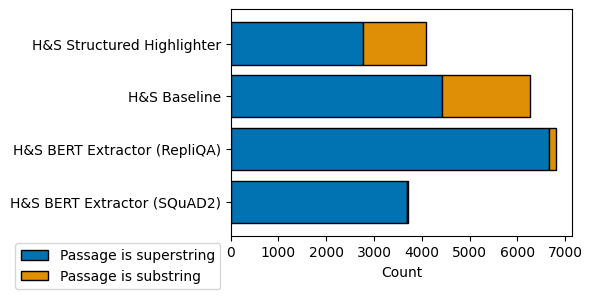

In [18]:
# Remove the cases where long_answer isn't a substring of the document_extracted.
df = df[df.apply(lambda x: x["long_answer"] in x["document_extracted"], axis=1)]

df["passage_is_substring"] = df.apply(
    lambda x: x["long_answer"] in x["highlighter_extracted"] if pd.notnull(x["highlighter_extracted"]) else False,
    axis=1
)
df["passage_is_superset"] = df.apply(
    lambda x: x["highlighter_extracted"] in x["long_answer"] if pd.notnull(x["highlighter_extracted"]) else False,
    axis=1
)
df["passage_matches_highlighted"] = df.apply(
    lambda x: x["highlighter_extracted"].strip() == x["long_answer"].strip() if pd.notnull(x["highlighter_extracted"]) else False,
    axis=1
)
df_analysis = df.groupby("run_id").apply(
    lambda x: pd.Series({
        "passage_is_substring": x["passage_is_substring"].sum(),
        "passage_is_superset": x["passage_is_superset"].sum(),
        "total": x["passage_is_substring"].sum() + x["passage_is_superset"].sum()
    })
).reset_index()
to_latex(df_analysis, columns=["total", "passage_is_superset", "passage_is_substring"],
    sort_by="total", ascending=False
)

df_analysis["run_id"] = df_analysis["run_id"].map(lambda x: PRETTY_NAMES.get(x, x))
# Rename columns.
df_analysis.rename(columns={
    "passage_is_superset": "Passage is superstring",
    "passage_is_substring": "Passage is substring"
}, inplace=True)
ax = df_analysis.set_index("run_id")[["Passage is superstring", "Passage is substring"]].plot(
    kind="barh",
    stacked=True,
    width=0.8,
    edgecolor="black",
    figsize=(6, 3),
)
plt.xlabel("Count")
plt.ylabel("")
plt.tight_layout()
plt.legend(bbox_to_anchor=(-0.01, 0))

In [20]:
# how many times they match exactly (average of df["passage_matches_highlighted"])
df.groupby("run_id").apply(
     lambda x: pd.Series({
         "passage_matches_highlighted": x["passage_matches_highlighted"].sum()
     })
 )

/tmp/ipykernel_3212822/2773254712.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("run_id").apply(


,passage_matches_highlighted
run_id,
HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini,4
HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini,139
HSBaseline-gpt-4.1-mini-gpt-4.1-mini,1072
HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini,531


## Can the summarizer guess what was the question? (Table 6, Figure 9)

In [35]:
for dataset_name, df in results_df.items():
    # Filter out no-answer predictions and QAEvaluator pipeline.
    df = df[df.pipeline != "QAEvaluator"]
    df = df[df.answer != NOANSWER_PRED]

    # Remove cases where the summarizer just got bad input.
    # (We leave those cases for the highlighter evaluation.)
    df = df[df.highlighter_extracted != ""]
    df = df[~pd.isnull(df.highlighter_extracted)]
    # We also discard cases where the summarizer guessed an empty question.
    # In those cases, the H&S pipeline should return "NOANSWER_PRED".
    df = df[df.summarizer_llm_guessed_question != ""]
    df = df[~pd.isnull(df.summarizer_llm_guessed_question)]

    print(f"Processing dataset: {dataset_name}")
    # Adlakha precision and recall.
    df["guessed_question_precision"], df["guessed_question_recall"] = adlakha_precision_recall(
        df["question"],
        df["question"],
        df["summarizer_llm_guessed_question"]
    )
    # BERT score.
    bertscores = bertscore.compute(
        predictions=list(df["summarizer_llm_guessed_question"]),
        references=list(df["question"]),
        lang="en"
    )
    df["summarizer_llm_guessed_question_bertscore_f1"] = bertscores["f1"]
    df["summarizer_llm_guessed_question_bertscore_precision"] = bertscores["precision"]
    df["summarizer_llm_guessed_question_bertscore_recall"] = bertscores["recall"]

    to_latex(df, ["guessed_question_precision", "guessed_question_recall"], sort_by="guessed_question_precision", ascending=False)
    to_latex(df,
        ["summarizer_llm_guessed_question_bertscore_precision", "summarizer_llm_guessed_question_bertscore_recall", "summarizer_llm_guessed_question_bertscore_f1"],
        sort_by="summarizer_llm_guessed_question_bertscore_f1",
        ascending=False
    )
    # Combined table with just F1.
    df["guessed_question_f1"] = 2/(df["guessed_question_precision"]**-1 + df["guessed_question_recall"]**-1)
    to_latex(df, ["guessed_question_f1", "summarizer_llm_guessed_question_bertscore_f1"], sort_by="summarizer_llm_guessed_question_bertscore_f1", ascending=False)

    # Worst examples.
    for run_id in df.run_id.unique():
        run_id_df = df[df.run_id == run_id]
        if len(run_id_df) == 0:
            continue
        worst_examples = run_id_df.sort_values("guessed_question_precision").head(3)
        print(f"% {run_id}")
        print("\\begin{tabularx}{\\textwidth}{cXX}")
        print("\\toprule")
        print("Score & Real question & Guessed question \\\\")
        print("\\midrule")
        for _, w in worst_examples.iterrows():
            print(f"{w.guessed_question_precision:.4f} & {w.question} & {w.summarizer_llm_guessed_question} \\\\")

        print("\\bottomrule")
        print("\\end{tabularx}")
        print("=" * 80)

Processing dataset: repliqa_3


/tmp/ipykernel_3189856/4239230744.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \
/tmp/ipykernel_3189856/4239230744.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \
/tmp/ipykernel_31898

\begin{tabular}{lrr}
\toprule
Run ID & guessed\_question\_precision & guessed\_question\_recall \\
\midrule
H\&S Structured Highlighter & 0.55 & 0.49 \\
H\&S Baseline & 0.46 & 0.39 \\
H\&S BERT Extractor (RepliQA) & 0.41 & 0.34 \\
H\&S BERT Extractor (SQuAD2) & 0.29 & 0.21 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
Run ID & summarizer\_llm\_guessed\_question\_bertscore\_precision & summarizer\_llm\_guessed\_question\_bertscore\_recall & summarizer\_llm\_guessed\_question\_bertscore\_f1 \\
\midrule
H\&S Structured Highlighter & 0.93 & 0.92 & 0.93 \\
H\&S Baseline & 0.92 & 0.91 & 0.91 \\
H\&S BERT Extractor (RepliQA) & 0.91 & 0.90 & 0.91 \\
H\&S BERT Extractor (SQuAD2) & 0.90 & 0.88 & 0.89 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
Run ID & guessed\_question\_f1 & summarizer\_llm\_guessed\_question\_bertscore\_f1 \\
\midrule
H\&S Structured Highlighter & 0.51 & 0.93 \\
H\&S Baseline & 0.41 & 0.91 \\
H\&S BERT Extractor (RepliQA) & 0.37 & 0.91 \\
H\&S BE

/tmp/ipykernel_3189856/4239230744.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \
/tmp/ipykernel_3189856/4239230744.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \
/tmp/ipykernel_31898

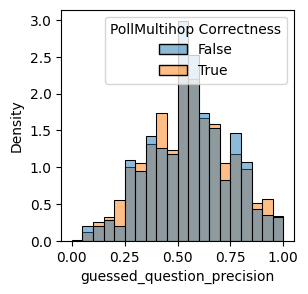

In [36]:
df = results_df["repliqa_3"]
dfhs = df[df.pipeline == "HSStructuredHighlighter"]
dfhs = dfhs[pd.notnull(dfhs.summarizer_llm_guessed_question)]
dfhs = dfhs[dfhs.answer != NOANSWER_PRED]
dfhs["guessed_question_precision"], dfhs["guessed_question_recall"] = adlakha_precision_recall(
    dfhs["question"],
    dfhs["question"],
    dfhs["summarizer_llm_guessed_question"]
)


plt.figure(figsize=(3, 3))
ax = sns.histplot(
    data=dfhs,
    x="guessed_question_precision",
    hue="PollMultihopCorrectness-gpt-4.1-mini_correctness_rating",
    stat="density",
    common_norm=False,
    bins=20,
)
ax.legend_.set_title("PollMultihop Correctness")

In [37]:
from scipy.stats import pearsonr

pearsonr(dfhs["guessed_question_precision"], dfhs["PollMultihopCorrectness-gpt-4.1-mini_correctness_rating"].astype(float))

PearsonRResult(statistic=np.float64(-0.0037567697602224545), pvalue=np.float64(0.6556270171157027))

## The importance of a generative summarizer (Fig 5)

Dataset: repliqa_3
\begin{tabular}{l|c}
\toprule
Preference & Count \\
\midrule
Tie & 0.5872 \\
H&S & 0.1693 \\
Highlighter & 0.1483 \\
Neither & 0.0953 \\
\bottomrule
\end{tabular}
Dataset: bioasq
\begin{tabular}{l|c}
\toprule
Preference & Count \\
\midrule
H&S & 0.5836 \\
Tie & 0.2759 \\
Neither & 0.0803 \\
Highlighter & 0.0602 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_3189856/876942191.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis = df.groupby("dataset_name").apply(


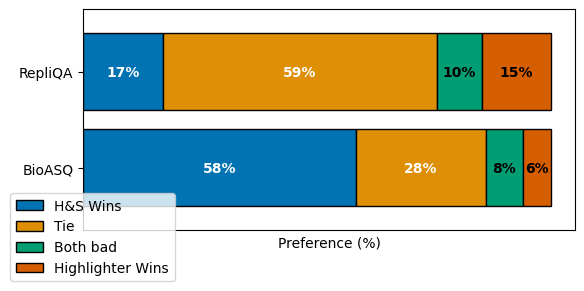

In [53]:
to_cat = []
for dataset_name in ["repliqa_3", "bioasq"]:
    dataset_folder = f"{RESULTS_DIR}/{dataset_name}/"
    for fname in os.listdir(dataset_folder):
        if not fname.endswith("highlighter_vs_hs.jsonl"):
            continue
        df = pd.read_json(os.path.join(dataset_folder, fname), lines=True)
        df["preference"] = df.preference.map(lambda x: PRETTY_NAMES.get(x, x))

        # As a latex table.
        print(f"Dataset: {dataset_name}")
        print("\\begin{tabular}{l|c}")
        print("\\toprule")
        print("Preference & Count \\\\")
        print("\\midrule")
        for pref, count in df.value_counts("preference").items():
            # Normalize by the total number of samples.
            print(f"{pref} & {count / len(df):.4f} \\\\")
        print("\\bottomrule")
        print("\\end{tabular}")
    
    df["dataset_name"] = dataset_name
    to_cat.append(df)

df = pd.concat(to_cat, ignore_index=True)
df_analysis = df.groupby("dataset_name").apply(
    lambda x: pd.Series({
        "H&S Wins": (x.preference == "H&S").mean(),
        "Tie": ((x.preference == "Tie")).mean(),
        "Both bad": (x.preference == "Neither").mean(),
        "Highlighter Wins": (x.preference == "Highlighter").mean(),
    })
).reset_index()

df_analysis["dataset_name"] = df_analysis["dataset_name"].map(PRETTY_NAMES)
plot_data = df_analysis.set_index("dataset_name")[["H&S Wins", "Tie", "Both bad", "Highlighter Wins"]]
ax = plot_data.plot(
    kind="barh",
    stacked=True,
    width=0.8,
    edgecolor="black",
    figsize=(6, 3),
)
plt.xlabel("Preference (%)")
plt.ylabel("")
plt.xticks([])
plt.legend(bbox_to_anchor=(0.2, 0.2))
plt.tight_layout()

# Add % labels to each bar segment
for i, (idx, row) in enumerate(plot_data.iterrows()):
    left = 0
    for col in plot_data.columns:
        value = row[col]
        if value > 0.01:  # Only label if >1%
            ax.text(left + value / 2, i, f"{value*100:.0f}%", va='center', ha='center', color="white" if value > 0.15 else "black", fontsize=10, fontweight="bold")
        left += value

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

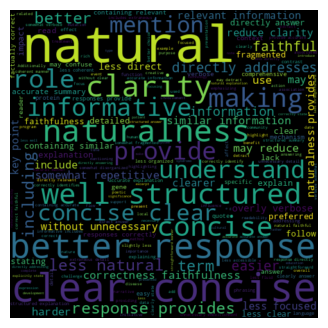

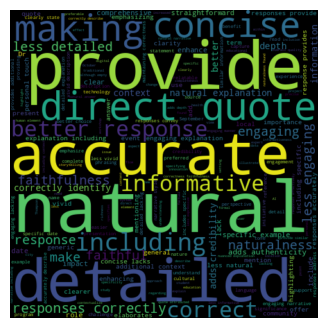

In [55]:
from wordcloud import WordCloud

text = "\n".join(df[df.preference == "H&S"].explanation.unique())
text = text.replace("Response", "").replace("question", "")
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)
plt.figure(figsize=(4, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

text = "\n".join(df[df.preference == "Highlighter"].explanation.unique())
text = text.replace("Response", "").replace("question", "")
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)
plt.figure(figsize=(4, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Full pipelines comparison: vanilla vs HS RAG

## Answerable questions

### K-precision and recall

In [8]:
for dataset_name, dataset_results in results_df.items():
    # Remove unanswerable.
    dataset_results = dataset_results[dataset_results.answer != NOANSWER_PRED]
    print(f"Dataset: {dataset_name}")

    df = dataset_results[dataset_results.answer != NOANSWER_PRED]
    if "long_answer" in df.columns:
        df = df[df.long_answer != ""]
        df = df[df.apply(lambda x: x["long_answer"] in x["document_extracted"], axis=1)]

        df["ref_passage_precision"], df["ref_answer_recall"] = adlakha_precision_recall(
            df["answer"],
            df["long_answer"],
            df["answer_pred"]
        )
    else:
        print("% Remember to add caveat in text here: bioasq does not have long_answer.")
        df["ref_passage_precision"], df["ref_answer_recall"] = adlakha_precision_recall(
            df["answer"],
            df["answer"],
            df["answer_pred"]
        )
    df = df.groupby("run_id").apply(
        lambda x: pd.Series({
            "ref_passage_precision": x["ref_passage_precision"].mean(),
            "ref_answer_recall": x["ref_answer_recall"].mean()
        })
    ).reset_index()
    to_latex(df, ["ref_passage_precision", "ref_answer_recall"], sort_by="ref_passage_precision", ascending=False)

Dataset: repliqa_3


/tmp/ipykernel_3212822/968619924.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("run_id").apply(
/tmp/ipykernel_3212822/2205205921.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \


\begin{tabular}{lrr}
\toprule
Run ID & ref\_passage\_precision & ref\_answer\_recall \\
\midrule
Vanilla RAG & 0.76 & 0.72 \\
H\&S Structured Highlighter & 0.68 & 0.74 \\
H\&S Baseline & 0.67 & 0.69 \\
H\&S BERT Extractor (RepliQA) & 0.62 & 0.60 \\
H\&S BERT Extractor (SQuAD2) & 0.47 & 0.34 \\
\bottomrule
\end{tabular}

Dataset: bioasq
% Remember to add caveat in text here: bioasq does not have long_answer.
\begin{tabular}{lrr}
\toprule
Run ID & ref\_passage\_precision & ref\_answer\_recall \\
\midrule
Vanilla RAG & 0.56 & 0.37 \\
H\&S Structured Highlighter & 0.31 & 0.55 \\
H\&S Baseline & 0.30 & 0.52 \\
H\&S BERT Extractor (SQuAD2) & 0.24 & 0.22 \\
H\&S BERT Extractor (RepliQA) & 0.24 & 0.30 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3212822/968619924.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("run_id").apply(
/tmp/ipykernel_3212822/2205205921.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \


### LLM as a judge

Dataset: repliqa_3
Dataset: bioasq


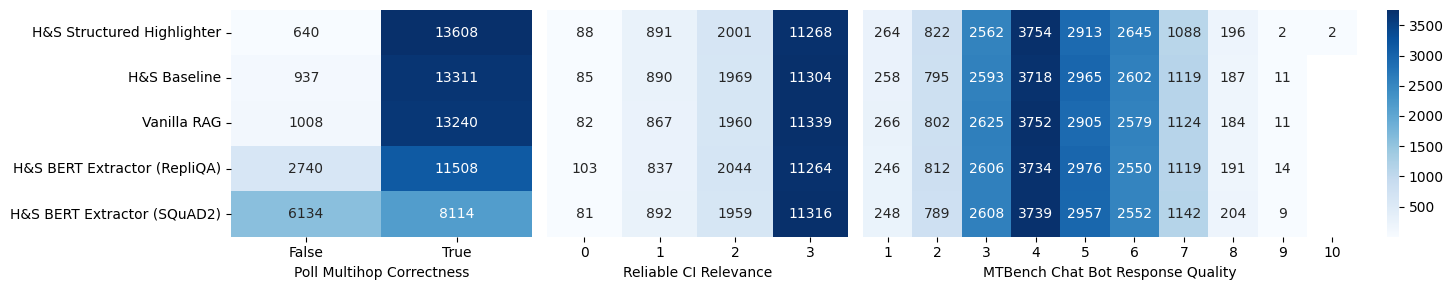

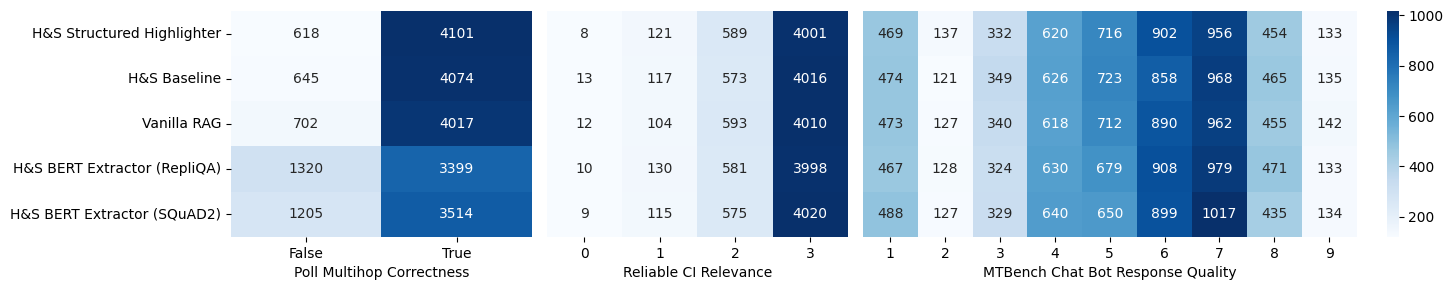

In [9]:
for dataset_name, dataset_results in results_df.items():
    print(f"Dataset: {dataset_name}")
    df = dataset_results[dataset_results.answer != NOANSWER_PRED]

    fig = plt.figure(figsize=(15, 3))
    cbar = False
    count = 0
    for count, judge in enumerate(["PollMultihopCorrectness-gpt-4.1-mini_correctness_rating", "ReliableCIRelevance-gpt-4.1-mini_quality_rating", "MTBenchChatBotResponseQuality-gpt-4.1-mini_quality_rating"]):
        df_relevance = {}
        for run_id, group in df.groupby("run_id"):
            df_relevance[run_id] = group.value_counts(judge).rename_axis("rating").reset_index(name="count")
        df_relevance = pd.concat(df_relevance, names=["run_id"]).reset_index()
        df_relevance["run_id"] = df_relevance["run_id"].map(PRETTY_NAMES)
        df_relevance.sort_values("count", ascending=False, inplace=True)
        df_relevance_pivot = df_relevance.pivot(index="run_id", columns="rating", values="count")
        # Sort by our preferred order.
        df_relevance_pivot = df_relevance_pivot.reindex(
            [
                "H&S Structured Highlighter",
                "H&S Baseline",
                "Vanilla RAG",
                "H&S BERT Extractor (RepliQA)",
                "H&S BERT Extractor (SQuAD2)",
            ],
            axis=0,
        )

        if count == 0:
            ax = first_ax = fig.add_subplot(1, 4, count + 1)
        elif count < 2:
            ax = fig.add_subplot(1, 4, count + 1, sharey=first_ax)
            ax.tick_params(axis='y', left=False, labelleft=False)
        else:
            ax = fig.add_subplot(1, 4, (3, 4), sharey=first_ax)
            ax.tick_params(axis='y', left=False, labelleft=False)
            cbar = True

        sns.heatmap(
            data=df_relevance_pivot,
            annot=True,
            fmt=".0f",
            cmap="Blues",
            cbar=cbar,
        )
        ax.set_xlabel(PRETTY_NAMES.get(judge, judge))
        ax.set_ylabel("")

    plt.tight_layout()

In [368]:
for dataset_name, dataset_results in results_df.items():
    df = dataset_results[dataset_results.answer != NOANSWER_PRED]

    judges = ["PollMultihopCorrectness-gpt-4.1-mini_correctness_rating", "ReliableCIRelevance-gpt-4.1-mini_quality_rating", "MTBenchChatBotResponseQuality-gpt-4.1-mini_quality_rating"]
    # max_rating = df[judge].max()
    print(f"Dataset: {dataset_name}")
    to_latex(df.groupby("run_id").apply(
            lambda x: pd.Series({
                judge: x[judge].mean() for judge in judges
            })
    ).reset_index(), columns=judges, ascending=False)

Dataset: bioasq
\begin{tabular}{lrrr}
\toprule
Run ID & PollMultihopCorrectness-gpt-4.1-mini\_correctness\_rating & ReliableCIRelevance-gpt-4.1-mini\_quality\_rating & MTBenchChatBotResponseQuality-gpt-4.1-mini\_quality\_rating \\
\midrule
H\&S Structured Highlighter & 0.87 & 2.82 & 5.24 \\
H\&S Baseline & 0.86 & 2.82 & 5.24 \\
Vanilla RAG & 0.85 & 2.82 & 5.25 \\
H\&S BERT Extractor (SQuAD2) & 0.74 & 2.82 & 5.24 \\
H\&S BERT Extractor (RepliQA) & 0.72 & 2.82 & 5.27 \\
\bottomrule
\end{tabular}

Dataset: repliqa_3
\begin{tabular}{lrrr}
\toprule
Run ID & PollMultihopCorrectness-gpt-4.1-mini\_correctness\_rating & ReliableCIRelevance-gpt-4.1-mini\_quality\_rating & MTBenchChatBotResponseQuality-gpt-4.1-mini\_quality\_rating \\
\midrule
H\&S Structured Highlighter & 0.96 & 2.72 & 4.51 \\
H\&S Baseline & 0.93 & 2.72 & 4.52 \\
Vanilla RAG & 0.93 & 2.72 & 4.51 \\
H\&S BERT Extractor (RepliQA) & 0.81 & 2.72 & 4.51 \\
H\&S BERT Extractor (SQuAD2) & 0.57 & 2.72 & 4.52 \\
\bottomrule
\end{tabular

/tmp/ipykernel_2283736/52436109.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  to_latex(df.groupby("run_id").apply(
/tmp/ipykernel_2283736/2916753748.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \
/tmp/ipykernel_2283736/52436109.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on th

## Unanswerable questions (Table 3)

In [12]:
df = results_df["repliqa_3"]

def unanswerable_precision(df):
    """When the pipeline predicts NOANSWER_PRED, how many of the answers are actually unanswerable?"""
    predicts_unanswerable = df.answer_pred == NOANSWER_PRED
    total = predicts_unanswerable.sum()
    if total == 0:
        return 0.0
    predicts_unanswerable_correct = predicts_unanswerable & (df.answer == NOANSWER_PRED)

    return np.sum(predicts_unanswerable_correct) / total

def unanswerable_recall(df):
    """When the answer is unanswerable, how many times does the pipeline predict NOANSWER_PRED?"""
    unanswerable = df.answer == NOANSWER_PRED
    total = unanswerable.sum()
    if total == 0:
        return 0.0
    predicts_unanswerable_correct = unanswerable & (df.answer_pred == NOANSWER_PRED)

    return np.sum(predicts_unanswerable_correct) / total


to_latex(
    df.groupby("run_id").apply(
        lambda x: pd.Series({
            "unanswerable_precision": unanswerable_precision(x),
            "unanswerable_recall": unanswerable_recall(x),
            "unanswerable_f1": 2 / (unanswerable_precision(x)**-1 + unanswerable_recall(x)**-1)
        })
    ).reset_index(),
    columns=["unanswerable_precision", "unanswerable_recall", "unanswerable_f1"],
    sort_by="unanswerable_f1",
    ascending=False
)

\begin{tabular}{lrrr}
\toprule
Run ID & unanswerable\_precision & unanswerable\_recall & unanswerable\_f1 \\
\midrule
H\&S BERT Extractor (RepliQA) & 0.85 & 0.99 & 0.91 \\
H\&S Structured Highlighter & 0.94 & 0.39 & 0.55 \\
H\&S BERT Extractor (SQuAD2) & 0.55 & 0.48 & 0.51 \\
Vanilla RAG & 0.95 & 0.32 & 0.48 \\
H\&S Baseline & 0.58 & 0.20 & 0.29 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2568306/3228191477.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("run_id").apply(
/tmp/ipykernel_2568306/1367142857.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tex = df.groupby("run_id").apply(lambda x: pd.Series({column: np.mean(x[column]) for column in columns})) \


# Pairwise comparisons

Load and convert to "battles" format for easier parsing.

In [4]:
def load_battles(dataset_name):
    dataset_results = f"{RESULTS_DIR}/{dataset_name}"
    battles = []
    for comparison in os.listdir(dataset_results):
        if not comparison.startswith("comparison-") or comparison.endswith("highlighter_vs_hs.jsonl"):
            continue
        model_a, model_b = comparison[len("comparison-"):-len(".jsonl")].split("_vs_")
        print(f"Processing comparison: {model_a} vs {model_b}")
        df = pd.read_json(os.path.join(dataset_results, comparison), lines=True)
        for _, row in df.iterrows():
            if row["preference"] == "neither":
                winner = "tie (bothbad)"
            elif row["preference"] in [model_a, model_b]:
                winner = "model_a" if row["preference"] == model_a else "model_b"
            elif row["preference"] == "tie":
                winner = "tie"
            else:
                raise ValueError(f"Unexpected preference value: {row['preference']}")

            battles.append({
                "model_a": model_a,
                "model_b": model_b,
                "winner": winner,
            })
    battles = pd.DataFrame(battles)
    all_models = pd.concat([battles["model_a"], battles["model_b"]]).unique()
    print(f"All models: {', '.join(all_models)}")
    return battles, all_models

def compute_battles_stats(battles, all_models):
    counts = {}
    for model in all_models:
        counts[model] = {}
        for other_model in all_models:
            if model == other_model:
                continue
            wins = ties = losses = 0
            # model is model_a, other_model is model_b.
            battles_for_pair = battles[(battles.model_a == model) & (battles.model_b == other_model)]
            wins += (battles_for_pair.winner == "model_a").sum()
            ties += ((battles_for_pair.winner == "tie") | (battles_for_pair.winner == "tie (bothbad)")).sum()
            losses += (battles_for_pair.winner == "model_b").sum()
            # model is model_b, other_model is model_a.
            battles_for_pair = battles[(battles.model_a == other_model) & (battles.model_b == model)]
            wins += (battles_for_pair.winner == "model_b").sum()
            ties += ((battles_for_pair.winner == "tie") | (battles_for_pair.winner == "tie (bothbad)")).sum()
            losses += (battles_for_pair.winner == "model_a").sum()

            counts[model][other_model] = {
                "wins": wins,
                "losses": losses,
                "ties": ties,
                "total": wins + losses + ties,
            }
    return counts

In [5]:
dataset_name = "repliqa_3"
battles = {}
battles_stats = {}
for dataset_name in ["repliqa_3", "bioasq"]:
    b, all_models = load_battles(dataset_name)
    battles[dataset_name] = b
    battles_stats[dataset_name] = compute_battles_stats(b, all_models)

Processing comparison: QAEvaluator-gpt-4.1-mini vs HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini


Processing comparison: QAEvaluator-gpt-4.1-mini vs HSBaseline-gpt-4.1-mini-gpt-4.1-mini
Processing comparison: QAEvaluator-gpt-4.1-mini vs HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini
Processing comparison: HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini vs HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini
Processing comparison: HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini vs HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini
Processing comparison: HSBaseline-gpt-4.1-mini-gpt-4.1-mini vs HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini
Processing comparison: HSBaseline-gpt-4.1-mini-gpt-4.1-mini vs HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini
Processing comparison: HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini vs HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini
Processing comparison: HSBaseline-gpt-4.1-mini-gpt-4.1-mini vs HSBERTExtractor-deepset_deberta-v3-base-squa

### Wins heatmap (Fig 2)

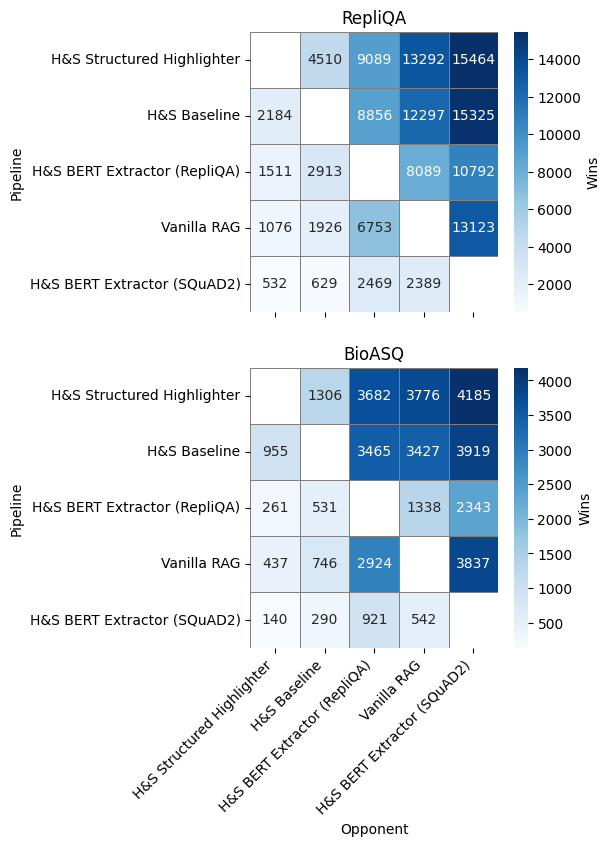

In [38]:
def battles_heatmap(battles_stats):
    all_models = list(battles_stats.keys())
    wins_matrix = pd.DataFrame(
        index=[PRETTY_NAMES[m] for m in all_models],
        columns=[PRETTY_NAMES[m] for m in all_models],
        data=0
    )

    for model in all_models:
        for other_model in all_models:
            if model == other_model:
                wins_matrix.loc[PRETTY_NAMES[model], PRETTY_NAMES[other_model]] = None
            else:
                wins_matrix.loc[PRETTY_NAMES[model], PRETTY_NAMES[other_model]] = battles_stats[model][other_model]["wins"]

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        wins_matrix.astype(float),
        annot=True,
        fmt=".0f",
        cmap="Blues",
        cbar_kws={'label': 'Wins'},
        linewidths=0.5,
        linecolor='gray'
    )
    plt.title("Pairwise Wins")
    plt.xlabel("Opponent")
    plt.ylabel("Pipeline")
    plt.tight_layout()

def battles_heatmap_joint(battles_stats):
    fig, axes = plt.subplots(2, 1, figsize=(4, 8), sharex=True)

    for ax, dataset_name in zip(axes, battles_stats.keys()):
        #all_models = list(battles_stats[dataset_name].keys())
        # Force our ordering:
        all_models = [
            'HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini',
            'HSBaseline-gpt-4.1-mini-gpt-4.1-mini',
            'HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini',
            'QAEvaluator-gpt-4.1-mini',
            'HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini',
        ]
        wins_matrix = pd.DataFrame(
            index=[PRETTY_NAMES[m] for m in all_models],
            columns=[PRETTY_NAMES[m] for m in all_models],
            data=0
        )

        for model in all_models:
            for other_model in all_models:
                if model == other_model:
                    wins_matrix.loc[PRETTY_NAMES[model], PRETTY_NAMES[other_model]] = None
                else:
                    wins_matrix.loc[PRETTY_NAMES[model], PRETTY_NAMES[other_model]] = battles_stats[dataset_name][model][other_model]["wins"]

        sns.heatmap(
            wins_matrix.astype(float),
            annot=True,
            fmt=".0f",
            cmap="Blues",
            cbar_kws={'label': 'Wins'},
            linewidths=0.5,
            linecolor='gray',
            ax=ax
        )
        ax.set_title(f"{PRETTY_NAMES[dataset_name]}")
        if ax == axes[1]:
            ax.set_xlabel("Opponent")
        else:
            ax.set_xticks([])
        ax.set_ylabel("Pipeline")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# for dataset_name in battles_stats:
#     print(f"Dataset: {dataset_name}")
#     battles_heatmap(battles_stats[dataset_name])
battles_heatmap_joint(battles_stats)

### Elo (Tab 2)

In [ ]:
def wins_elo_table(battles, battles_stats):
    all_models = list(battles_stats.keys())

    # Print total wins for each model.
    total_wins = {model: 0 for model in all_models}
    average_wins = {model: 0 for model in all_models}
    for model in all_models:
        num_battles_for_model = 0
        for other_model in all_models:
            if model == other_model:
                continue
            total_wins[model] += battles_stats[model][other_model]["wins"]
            num_battles_for_model += battles_stats[model][other_model]["total"]
        average_wins[model] = total_wins[model] / num_battles_for_model
    print("Total wins for each model:")
    print(total_wins)
    print("Average wins for each model:")
    print(average_wins)

    elo = compute_elo(battles)
    elo_ties = compute_elo_mle_with_tie(battles)
    print("Elo ratings:")
    print(elo)
    print("Elo ratings with ties:")
    print(elo_ties)
    print()

    df = pd.DataFrame.from_dict(average_wins, orient='index', columns=['Average Wins']).sort_values('Average Wins', ascending=False)
    df["Elo"] = [int(elo[model]) for model in df.index]
    df["Average Wins"] = df["Average Wins"].map(lambda x: f"{x*100:.0f}\\%")
    df.index = df.index.map(PRETTY_NAMES)
    print(df.to_latex(float_format="%.2f", escape=False, index=True, caption="Average wins for each model in pairwise battles.", label="tab:average_wins").replace("_", "\\_").replace("H&S", "H\\&S"))

for dataset_name in battles_stats:
    print(f"Dataset: {dataset_name}")
    wins_elo_table(battles[dataset_name], battles_stats[dataset_name])
    print("=" * 80)

Dataset: repliqa_3
Total wins for each model:
{'QAEvaluator-gpt-4.1-mini': np.int64(22878), 'HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini': np.int64(6019), 'HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini': np.int64(42355), 'HSBaseline-gpt-4.1-mini-gpt-4.1-mini': np.int64(38662), 'HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini': np.int64(23305)}
Average wins for each model:
{'QAEvaluator-gpt-4.1-mini': np.float64(0.31854636591478697), 'HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini': np.float64(0.08380673906989697), 'HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini': np.float64(0.5897382344750766), 'HSBaseline-gpt-4.1-mini-gpt-4.1-mini': np.float64(0.5383180172653856), 'HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini': np.float64(0.32449178501810083)}
Elo ratings:
{'QAEvaluator-gpt-4.1-mini': 958.5382407624481, 'HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini': 1211.6444981900559, 'HSBaseline-gpt-4.1-mini-gpt

### Detailed table

In [151]:
SHORT_NAMES = {
    "HSStructuredHighlighter-gpt-4.1-mini-gpt-4.1-mini": "Structured",
    "HSBaseline-gpt-4.1-mini-gpt-4.1-mini": "Baseline",
    "HSBERTExtractor-models_microsoft-deberta-v3-base-repliqa-gpt-4.1-mini": "BERT (RepliQA)",
    "QAEvaluator-gpt-4.1-mini": "RAG",
    "HSBERTExtractor-deepset_deberta-v3-base-squad2-gpt-4.1-mini": "BERT (SQuAD2)",
}

def detailed_wins_table(battles_stats):
    all_models = list(battles_stats.keys())
    columns = pd.MultiIndex.from_product(
        [[SHORT_NAMES[m] for m in all_models], ["Wins", "Ties"]],
        names=["Opponent", ""]
    )
    # Add total columns at the end
    columns = columns.append(pd.MultiIndex.from_tuples([
        ("Total", "Wins"),
        ("Total", "Ties")
    ], names=["Opponent", ""]))

    rows = []
    row_labels = []
    for model in all_models:
        row = []
        total_wins = 0
        total_ties = 0
        for other_model in all_models:
            if model == other_model:
                row.extend(["--", "--"])
            else:
                c = battles_stats[model][other_model]
                row.extend([c["wins"], c["ties"]])
                total_wins += c["wins"]
                total_ties += c["ties"]
        row.extend([total_wins, total_ties])
        rows.append(row)
        row_labels.append(SHORT_NAMES[model])

    df_latex = pd.DataFrame(rows, index=row_labels, columns=columns)

    # Print LaTeX table
    print(df_latex.to_latex(
        multicolumn=True,
        multirow=True,
        index=True,
        escape=False,
        caption="Pairwise battle results: Each cell shows (Wins, Ties) for the row model vs the column model. The last columns show total wins and ties.",
        label="tab:battle_results"
    ).replace("H&S", "H\\&S").replace("_", "\\_"))

for dataset_name in battles_stats:
    print(f"Dataset: {dataset_name}")
    detailed_wins_table(battles_stats[dataset_name])
    print("=" * 80)
    print()

Dataset: repliqa_3
\begin{table}
\caption{Pairwise battle results: Each cell shows (Wins, Ties) for the row model vs the column model. The last columns show total wins and ties.}
\label{tab:battle\_results}
\begin{tabular}{lllllllllllrr}
\toprule
Opponent & \multicolumn{2}{r}{RAG} & \multicolumn{2}{r}{BERT (SQuAD2)} & \multicolumn{2}{r}{Structured} & \multicolumn{2}{r}{Baseline} & \multicolumn{2}{r}{BERT (RepliQA)} & \multicolumn{2}{r}{Total} \\
 & Wins & Ties & Wins & Ties & Wins & Ties & Wins & Ties & Wins & Ties & Wins & Ties \\
\midrule
RAG & -- & -- & 13123 & 2443 & 1076 & 3587 & 1926 & 3732 & 6753 & 3113 & 22878 & 12875 \\
BERT (SQuAD2) & 2389 & 2443 & -- & -- & 532 & 1959 & 629 & 2001 & 2469 & 4694 & 6019 & 11097 \\
Structured & 13292 & 3587 & 15464 & 1959 & -- & -- & 4510 & 11261 & 9089 & 7355 & 42355 & 24162 \\
Baseline & 12297 & 3732 & 15325 & 2001 & 2184 & 11261 & -- & -- & 8856 & 6186 & 38662 & 23180 \\
BERT (RepliQA) & 8089 & 3113 & 10792 & 4694 & 1511 & 7355 & 2913 & 6186